In [166]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
reps=5
nn=[10,15,20,25,30,35,40,45,50,55,60,80,100,120,140]
ylabels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)
xlabels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)
xlabels=xlabels.values.flatten().tolist()
ylabels=ylabels.values.flatten().tolist()

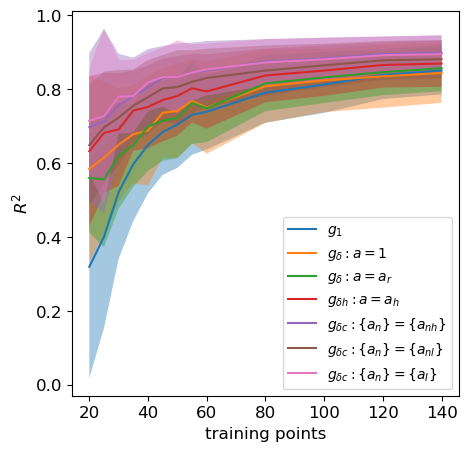

In [191]:
R2_s=pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/csv_files/DiscrepR2TrainNVaryDefinitiveAtria.csv",header=None).values.reshape(7,len(nn),7,reps)

plt.rcParams["figure.figsize"] = (5,5)
fontS=12


o=5
lim=2
lim2=15
y_lim=[0.5,1.01]

plt.plot(nn[lim:lim2],R2_s.mean(axis=(2,3))[:,lim:lim2].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=(2,3))[i,lim:lim2]+R2_s.std(axis=(2,3))[i,lim:lim2], R2_s.mean(axis=(2,3))[i,lim:lim2]-R2_s.std(axis=(2,3))[i,lim:lim2],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTDiscrepATATAtria.pdf' )



In [190]:
R2_s.mean(axis=(2,3))

array([[-24.48308123,  -0.46421908,   0.31930195,   0.40045361,
          0.5215093 ,   0.59730386,   0.64921748,   0.68428793,
          0.70436554,   0.73084345,   0.73894281,   0.79064602,
          0.81262386,   0.83876111,   0.85056701],
       [-13.63816365,   0.25582742,   0.58443377,   0.61452635,
          0.64995726,   0.6781823 ,   0.68806137,   0.73618682,
          0.74133609,   0.76814852,   0.75028419,   0.80809389,
          0.82388539,   0.83500497,   0.84375652],
       [-17.63059164,  -0.05896576,   0.55978338,   0.55603017,
          0.61996843,   0.64883588,   0.69880056,   0.71492759,
          0.72222341,   0.76274103,   0.74813497,   0.81572328,
          0.83206103,   0.84608173,   0.85715181],
       [-11.37941142,   0.18315707,   0.63208125,   0.68166975,
          0.69132355,   0.74221202,   0.75205672,   0.77073999,
          0.7816302 ,   0.80269565,   0.79406229,   0.83731856,
          0.85045574,   0.86567946,   0.86952615],
       [ -3.5383652 ,   0.36

In [155]:
R2_s

array([[[[-1.42972803e+00, -3.41224365e+01, -4.86660233e+01,
          -2.74109960e+00, -5.48783016e+00],
         [-2.68302321e+00, -3.93535347e+01, -1.10735413e+02,
          -2.67764683e+01, -6.59886312e+00],
         [-8.74147511e+00, -4.98706665e+01, -5.02508850e+01,
          -5.65828276e+00, -3.78871536e+00],
         ...,
         [-2.61855435e+00, -1.91765296e+00, -3.36350784e+01,
          -1.00117648e+00, -5.12404966e+00],
         [-7.96180820e+00, -1.72549011e+02, -1.33367493e+02,
          -1.60019207e+01, -4.53754473e+00],
         [-3.99698067e+00, -1.17248926e+01, -3.64525909e+01,
          -3.85161328e+00, -2.04181480e+00]],

        [[ 1.71913505e-01, -1.26865101e+00, -1.31586552e-01,
          -1.13598295e-01,  3.87987554e-01],
         [-6.19379282e-02, -1.65167868e+00, -2.44873911e-01,
          -2.27177262e+00,  4.44425553e-01],
         [-4.43860441e-01, -1.87172651e+00, -1.95279169e+00,
          -2.97863841e-01,  3.07216525e-01],
         ...,
         [ 3.624

(7, 7, 5)

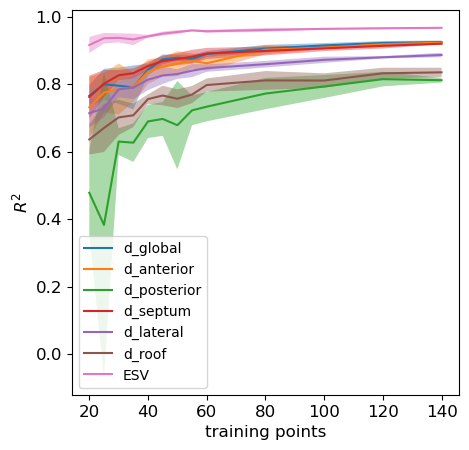

In [192]:
o=1
plt.plot(nn[lim:lim2],R2_s.mean(axis=(3))[6,lim:lim2])
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
#plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
plt.legend(ylabels)
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[6,lim:lim2,i]+R2_s.std(axis=3)[6,lim:lim2,i], R2_s.mean(axis=3)[6,lim:lim2,i]-R2_s.std(axis=3)[6,lim:lim2,i],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('figures/WeavingDTDiscrepVTATAtria.pdf' )
#plt.axhline(y = 0.8, color = 'r', linestyle = '-') 
R2_s[:,3].shape



In [193]:
R2_s.mean(axis=(3)).shape

(7, 15, 7)

In [194]:
R2_s.mean(axis=(3))[6,lim:lim2].T

array([[0.76542056, 0.79946904, 0.79507269, 0.79007215, 0.84230241,
        0.87314699, 0.87807093, 0.87476344, 0.88906059, 0.9050977 ,
        0.91456298, 0.92181929, 0.9244791 ],
       [0.73122907, 0.77495701, 0.78537537, 0.79090902, 0.83679639,
        0.85093466, 0.86052995, 0.86891716, 0.86161418, 0.90181806,
        0.90758599, 0.91802709, 0.92255371],
       [0.47811215, 0.38290378, 0.62972878, 0.62647432, 0.68941907,
        0.69682257, 0.67824149, 0.72223265, 0.7330487 , 0.77192063,
        0.79282382, 0.81464261, 0.81150396],
       [0.76164566, 0.80126173, 0.82606336, 0.83227943, 0.85328735,
        0.86795084, 0.87398247, 0.88098084, 0.89062194, 0.89812443,
        0.90577686, 0.91333827, 0.91950858],
       [0.71384275, 0.72837578, 0.78446968, 0.78963929, 0.8129747 ,
        0.82561461, 0.82983578, 0.83976951, 0.84742827, 0.85888954,
        0.87189214, 0.87940774, 0.88618817],
       [0.63595628, 0.66997716, 0.70128529, 0.70758725, 0.75563219,
        0.76613997, 0.75666

(7, 7, 5)

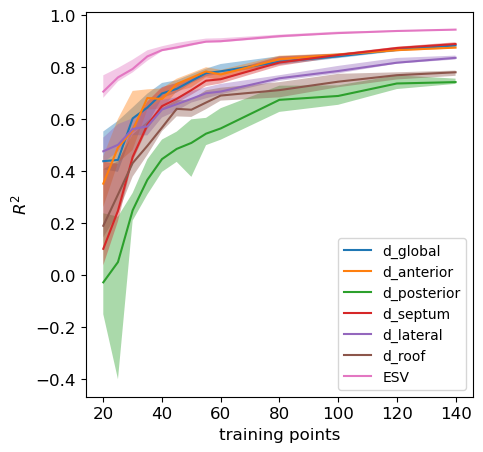

In [195]:
o=0
plt.plot(nn[lim:lim2],R2_s.mean(axis=(3))[o,lim:lim2])
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
#plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
plt.legend(ylabels)
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[o,lim:lim2,i]+R2_s.std(axis=3)[o,lim:lim2,i], R2_s.mean(axis=3)[o,lim:lim2,i]-R2_s.std(axis=3)[6,lim:lim2,i],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepVTATAtria.pdf' )

R2_s[:,3].shape

In [196]:
R2_s=pd.read_csv("DiscrepR2TrainNVaryDefinitiveAtria.csv",header=None).values.reshape(7,len(nn),7,reps)

plt.rcParams["figure.figsize"] = (5,5)
fontS=12


o=0
lim=10
lim2=15
y_lim=[0.987,1.001]

plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepATATHighAtria.pdf' )



FileNotFoundError: [Errno 2] No such file or directory: 'DiscrepR2TrainNVaryDefinitiveAtria.csv'

(0.5, 1.01)

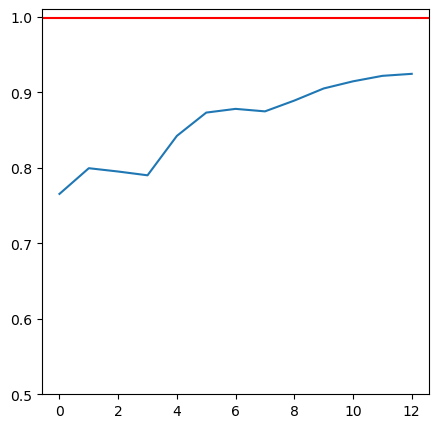

In [197]:
plt.plot(R2_s.mean(axis=3)[:,lim:lim2,o].T[:,6])
plt.axhline(y = 0.9985, color = 'r', linestyle = '-') 
plt.ylim(y_lim)

(7, 7, 5)

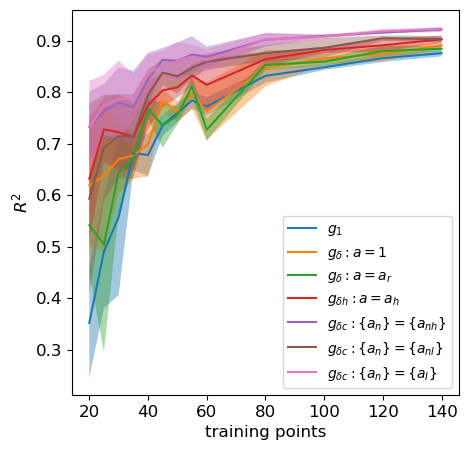

In [198]:
o=1
plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.savefig('WeavingDTDiscrepVTATHighAtria.pdf' )

R2_s[:,3].shape



In [199]:
tpr=6

In [200]:
nn[tpr]

40

In [201]:
plt.rcParams["figure.figsize"] = (2,2)

nn

results=pd.DataFrame((R2_s[:,tpr ].mean(axis=2)))

results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']

#results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,0,1,2,3,4,5,6
\$g_1\$,0.699100,0.677863,0.446374,0.650305,0.637239,0.567717,0.865924
\$g_{\delta}:a=1\$,0.713102,0.698292,0.447834,0.760149,0.703648,0.578490,0.914915
\$g_{\delta}:a=a_r\$,0.737087,0.766465,0.508705,0.674127,0.676834,0.641980,0.886406
\$g_{\delta h}:a=a_h\$,0.771974,0.774780,0.572802,0.811960,0.731376,0.672275,0.929230
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,0.843624,0.825367,0.607447,0.857285,0.810249,0.746907,0.942751
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,0.809599,0.794637,0.613641,0.804530,0.782988,0.706968,0.938090
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,0.842302,0.836796,0.689419,0.853287,0.812975,0.755632,0.941518


In [202]:
ands=pd.DataFrame(['&','&','&','&','&','&','&'])

In [203]:
results = pd.DataFrame((R2_s[:,i ].mean(axis=2)))

In [204]:
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)

In [205]:
results = pd.DataFrame((R2_s[:,2 ].mean(axis=2)))
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)
for i in [6,10]:
    results1=pd.DataFrame((R2_s[:,i ].mean(axis=2)))
    results=pd.concat([results,ands,results1.iloc[:,0],ands,results1.iloc[:,1]],axis=1)
results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']
    

In [206]:
results.round(3)

,0,0,0,1,0,0,0,1,0,0,0,1
\$g_1\$,&,0.438,&,0.352,&,0.699,&,0.678,&,0.784,&,0.772
\$g_{\delta}:a=1\$,&,0.628,&,0.619,&,0.713,&,0.698,&,0.813,&,0.763
\$g_{\delta}:a=a_r\$,&,0.571,&,0.541,&,0.737,&,0.766,&,0.749,&,0.727
\$g_{\delta h}:a=a_h\$,&,0.678,&,0.632,&,0.772,&,0.775,&,0.835,&,0.814
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,&,0.736,&,0.733,&,0.844,&,0.825,&,0.891,&,0.868
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,&,0.651,&,0.593,&,0.810,&,0.795,&,0.867,&,0.859
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,&,0.765,&,0.731,&,0.842,&,0.837,&,0.889,&,0.862


In [207]:
t=np.array([[0.9958, 0.9964, 0.9958, 0.9946, 0.9967],[0.9920, 0.9889, 0.9895, 0.9912, 0.9888]])

In [208]:
t.mean(axis=1)

array([0.99586, 0.99008])

In [209]:
nn[13]

120

In [210]:
results = pd.DataFrame((R2_s[:,12 ].mean(axis=2)))
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)
for i in [13,14]:
    results1=pd.DataFrame((R2_s[:,i ].mean(axis=2)))
    results=pd.concat([results,ands,results1.iloc[:,0],ands,results1.iloc[:,1]],axis=1)
results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']
    

In [211]:
0.884 0.876 0.743 0.889 0.836 0.781 0.945

SyntaxError: invalid syntax (411199783.py, line 1)

In [212]:
results.round(3)

,0,0,0,1,0,0,0,1,0,0,0,1
\$g_1\$,&,0.842,&,0.848,&,0.867,&,0.866,&,0.884,&,0.876
\$g_{\delta}:a=1\$,&,0.867,&,0.865,&,0.875,&,0.874,&,0.883,&,0.891
\$g_{\delta}:a=a_r\$,&,0.858,&,0.859,&,0.850,&,0.880,&,0.875,&,0.884
\$g_{\delta h}:a=a_h\$,&,0.880,&,0.882,&,0.893,&,0.891,&,0.895,&,0.902
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,&,0.915,&,0.909,&,0.922,&,0.916,&,0.924,&,0.921
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,&,0.888,&,0.886,&,0.898,&,0.905,&,0.903,&,0.903
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,&,0.915,&,0.908,&,0.922,&,0.918,&,0.924,&,0.923


In [213]:
res=pd.DataFrame(R2_s[6].mean(axis=2))
res.index=nn
res.columns=ylabels
res.round(3).loc[[100]].mean(axis=1)

100    0.881286
dtype: float64

In [214]:
res=pd.DataFrame(R2_s[5].mean(axis=2))
res.index=nn
res.columns=ylabels
res.round(3).loc[[100]].mean(axis=1)

100    0.864714
dtype: float64

In [215]:
res=pd.DataFrame(R2_s[6].mean(axis=2))
res.index=nn
res.columns=ylabels
res.round(3).loc[[20,40,60,80,100,120,140]]

,d_global,d_anterior,d_posterior,d_septum,d_lateral,d_roof,ESV
20,0.765,0.731,0.478,0.762,0.714,0.636,0.916
40,0.842,0.837,0.689,0.853,0.813,0.756,0.942
60,0.889,0.862,0.733,0.891,0.847,0.797,0.956
80,0.905,0.902,0.772,0.898,0.859,0.811,0.960
100,0.915,0.908,0.793,0.906,0.872,0.811,0.964
120,0.922,0.918,0.815,0.913,0.879,0.832,0.965
140,0.924,0.923,0.812,0.920,0.886,0.835,0.967


In [216]:
ands=pd.DataFrame(['&','&','&','&','&','&','&'])

In [217]:
slashes=pd.DataFrame(['\\\\','\\\\','\\\\','\\\\','\\\\','\\\\','\\\\'])

In [218]:
slashes

,0
0,\\
1,\\
2,\\
3,\\
4,\\
5,\\
6,\\


In [219]:
R2_s[0].shape

(15, 7, 5)

In [220]:
R2_s[0].mean(axis=2).shape

(15, 7)

In [221]:
res=pd.DataFrame(R2_s[6].mean(axis=2))
res.index=nn
res.columns=ylabels
res1 = res.round(3).loc[[20,40,60,80,100,120,140]]
ands.index=res1.index
slashes.index=res1.index
ands.columns=['&']

In [222]:
res1.shape

(7, 7)

In [223]:
res2 = pd.concat([ands,res1.iloc[:,0]],axis=1)
for i in range (res1.shape[0]-1):
    n=i+1
    res2 = pd.concat([res2,ands,res1.iloc[:,n]],axis=1)
res2=pd.concat([res2,slashes],axis=1)    

In [224]:
res2

,&,d_global,&,d_anterior,&,d_posterior,&,d_septum,&,d_lateral,&,d_roof,&,ESV,0
20,&,0.765,&,0.731,&,0.478,&,0.762,&,0.714,&,0.636,&,0.916,\\
40,&,0.842,&,0.837,&,0.689,&,0.853,&,0.813,&,0.756,&,0.942,\\
60,&,0.889,&,0.862,&,0.733,&,0.891,&,0.847,&,0.797,&,0.956,\\
80,&,0.905,&,0.902,&,0.772,&,0.898,&,0.859,&,0.811,&,0.960,\\
100,&,0.915,&,0.908,&,0.793,&,0.906,&,0.872,&,0.811,&,0.964,\\
120,&,0.922,&,0.918,&,0.815,&,0.913,&,0.879,&,0.832,&,0.965,\\
140,&,0.924,&,0.923,&,0.812,&,0.920,&,0.886,&,0.835,&,0.967,\\
